# Charting Boulder: Population growth - Rebuttal

[Brian C. Keegan, Ph.D.](http://www.brianckeegan.com)  
July 2025

Released under a [MIT License](https://opensource.org/licenses/MIT).

### Import packages

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100
idx = pd.IndexSlice

%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

import json, requests

### Read data

Load the "Workplace Area Characteristics" (WAC) and "Residence Area Characteristics" (RAC) data from [LODES](https://lehd.ces.census.gov/). Jobs are totaled by work Census Block for the City of Boulder.

In [2]:
wac_city_df = pd.read_csv('wac-boulder.csv')
rac_city_df = pd.read_csv('rac-boulder.csv')

wac_city_df.head()

,w_geocode,segment,year,C000
0,80130137042000,S000,2002,4
1,80130137042010,S000,2002,18
2,80130137043020,S000,2002,14
3,80130137044011,S000,2002,1
4,80130137044029,S000,2002,46


Load [housing data](https://demography.dola.colorado.gov/assets/html/housing.html) from the State Demography Office.

In [3]:
muni_pop_housing_df = pd.read_excel('muni-pop-housing.xlsx',header=1)

# Filter SDO housing data to City of Boulder
c0 = muni_pop_housing_df['PLACE'] == 'Boulder'
pop_housing_boulder_df = muni_pop_housing_df[c0]

pop_housing_boulder_df.head()

,YEAR,COUNTY,PLACE,CFIPS,PFIPS,Total Population,Household Population,Group Quarters Population,Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Vacancy Percent,Household Population to Total Housing Units Ratio
27,2010,Boulder County,Boulder,13,7850,97901,89349,8552,2.16,43497,41365.0,2132.0,4.90,2.054142
384,2011,Boulder County,Boulder,13,7850,100233,91034,9199,2.16,43908,42089.0,1819.0,4.14,2.073290
741,2012,Boulder County,Boulder,13,7850,101701,91797,9904,2.16,43863,42403.0,1460.0,3.33,2.092812
1098,2013,Boulder County,Boulder,13,7850,103443,92863,10580,2.17,44144,42854.0,1290.0,2.92,2.103638
1455,2014,Boulder County,Boulder,13,7850,105583,94326,11257,2.17,44869,43476.0,1393.0,3.10,2.102253


Load [historical CU enrollment data](https://data.colorado.edu/reports/enrollment-cu-boulder-1877).

In [4]:
cu_enrollments_df = pd.read_csv('cu-enrollments.csv',sep='\t')
cu_enrollments_df.tail()

,Year as Date,Highlight Dot,Annotation Button,Term,Year,All Students,Female,Graduate,Male,Nonresident,Resident,Total,Total Female Students,Total Graduate Students,Total Male Students,Total Nonresidents,Total Residents,Total Undergraduate Students,Undergraduate
144,2021,False,Hide Annotations,Spring,2021,NaN,14946.0,5861.0,17831.0,13135.0,19642.0,32777.0,NaN,5861.0,NaN,NaN,NaN,26916.0,26916.0
145,2022,False,Hide Annotations,Spring,2022,NaN,14856.0,6091.0,18301.0,14061.0,19096.0,33157.0,NaN,6091.0,NaN,NaN,NaN,27066.0,27066.0
146,2023,False,Hide Annotations,Spring,2023,NaN,15336.0,6264.0,18487.0,14410.0,19413.0,33823.0,NaN,6264.0,NaN,NaN,NaN,27559.0,27559.0
147,2024,False,Hide Annotations,Spring,2024,NaN,15958.0,6158.0,18800.0,14678.0,20080.0,34758.0,NaN,6158.0,NaN,NaN,NaN,28600.0,28600.0
148,2025,True,Hide Annotations,Spring,2025,NaN,16563.0,6219.0,19204.0,14940.0,20827.0,35767.0,NaN,6219.0,NaN,NaN,NaN,29548.0,29548.0


Load SDO [annual population estimate data](https://demography.dola.colorado.gov/assets/html/population.html) for counties and municipalities from 1980 to present.

In [5]:
county_muni_df = pd.read_csv('county-muni-timeseries.csv')

# Clean
county_muni_df['municipalityname'] = county_muni_df['municipalityname'].str.strip()

# Filter to Boulder County and city of Boulder
city_pop_s = county_muni_df.loc[county_muni_df['municipalityname'] == 'Boulder',['year','totalpopulation']].set_index('year')['totalpopulation']

# Inspect
city_pop_s.tail()

year
2019    108496.0
2020    108965.0
2021    104704.0
2022    107037.0
2023    106852.0
Name: totalpopulation, dtype: float64

Load historical estimates of populations for places and counties from [IPUMS NHGIS](https://www.nhgis.org/).

In [6]:
nhgis_county_df = pd.read_csv('nhgis-ts-county.csv',dtype={'STATEFP':str,'STATENH':str,'COUNTYFP':str,'COUNTYNH':str})

nhgis_place_df = pd.read_csv('nhgis-ts-place.csv',dtype={'STATEFP':str,'STATENH':str,'PLACEA':str})

nhgis_place_df.head()

,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,GJOIN2020,STATE,STATEFP,STATENH,PLACE,PLACEA,NAME1970,NAME1980,NAME1990,NAME2000,NAME2010,NAME2020,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA2020
0,G01000100,NaN,NaN,NaN,NaN,G01000100,G01000100,Alabama,01,010,Abanda CDP,00100,NaN,NaN,NaN,NaN,Abanda CDP,Abanda CDP,NaN,NaN,NaN,NaN,192.0,133.0
1,G01000124,G0100005,G0100005,G01000124,G01000124,G01000124,G01000124,Alabama,01,010,Abbeville city,00124,Abbeville,ABBEVILLE CITY,Abbeville city,Abbeville city,Abbeville city,Abbeville city,2996.0,3155.0,3173.0,2987.0,2688.0,2358.0
2,G01000460,G0100010,G0100010,G01000460,G01000460,G01000460,G01000460,Alabama,01,010,Adamsville city,00460,Adamsville,ADAMSVILLE CITY,Adamsville city,Adamsville city,Adamsville city,Adamsville city,2412.0,2498.0,4161.0,4965.0,4522.0,4366.0
3,G01000484,G0100015,G0100015,G01000484,G01000484,G01000484,G01000484,Alabama,01,010,Addison town,00484,Addison,ADDISON TOWN,Addison town,Addison town,Addison town,Addison town,NaN,746.0,626.0,723.0,758.0,659.0
4,G01000676,G0100020,G0100020,G01000676,G01000676,G01000676,G01000676,Alabama,01,010,Akron town,00676,Akron,AKRON TOWN,Akron town,Akron town,Akron town,Akron town,NaN,604.0,468.0,521.0,356.0,225.0


Load similar cities.

In [7]:
with open('similar-boulder.json','r') as f:
    similar_cities = json.load(f)

print(len(similar_cities))

similar_cities[:3]

26


[{'city': 'Boulder',
  'state': 'Colorado',
  'place_fips': '0807850',
  'county': 'Boulder County',
  'county_fips': '08013',
  'msa': 'Boulder, CO MSA'},
 {'city': 'Ann Arbor',
  'state': 'Michigan',
  'place_fips': '2603000',
  'county': 'Washtenaw County',
  'county_fips': '26161',
  'msa': 'Ann Arbor, MI MSA'},
 {'city': 'Cambridge',
  'state': 'Massachusetts',
  'place_fips': '2511000',
  'county': 'Middlesex County',
  'county_fips': '25017',
  'msa': 'Boston–Cambridge–Newton, MA–NH MSA'}]

## Data preparation and cleaning

Filter NHGIS data to `similar_d` entries.

In [14]:
nhgis_place_fips_l = []
for city in similar_cities:
    state = city['place_fips'][:2]
    place = city['place_fips'][2:]
    nhgis_place_fips_l.append('G{}{:06d}'.format(state, int(place)))

nhgis_similar_place_df = nhgis_place_df.loc[nhgis_place_df['NHGISCODE'].isin(nhgis_place_fips_l),:]

# Manually enter missing Irvine population
nhgis_similar_place_df.loc[2924,'AV0AA1970'] = 7381	

print(len(nhgis_similar_place_df))

nhgis_similar_place_df.head()

26


,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,GJOIN2020,STATE,STATEFP,STATENH,PLACE,PLACEA,NAME1970,NAME1980,NAME1990,NAME2000,NAME2010,NAME2020,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA2020
293,G01037000,G0100935,G0100935,G01037000,G01037000,G01037000,G01037000,Alabama,01,010,Huntsville city,37000,Huntsville,HUNTSVILLE CITY,Huntsville city,Huntsville city,Huntsville city,Huntsville city,137802.0,142513.0,159789.0,158216.0,180105.0,215006.0
1477,G04073000,G0400360,G0400360,G04073000,G04073000,G04073000,G04073000,Arizona,04,040,Tempe city,73000,Tempe,TEMPE CITY,Tempe city,Tempe city,Tempe city,Tempe city,62907.0,106743.0,141865.0,158625.0,161719.0,180587.0
2313,G06006000,G0600245,G0600245,G06006000,G06006000,G06006000,G06006000,California,06,060,Berkeley city,06000,Berkeley,BERKELEY CITY,Berkeley city,Berkeley city,Berkeley city,Berkeley city,116716.0,103328.0,102724.0,102743.0,112580.0,124321.0
2924,G06036770,NaN,G0601347,G06036770,G06036770,G06036770,G06036770,California,06,060,Irvine city,36770,NaN,IRVINE CITY,Irvine city,Irvine city,Irvine city,Irvine city,7381.0,62134.0,110330.0,143072.0,212375.0,307670.0
3243,G06049670,G0601860,G0601860,G06049670,G06049670,G06049670,G06049670,California,06,060,Mountain View city,49670,Mountain View,MOUNTAIN VIEW CITY,Mountain View city,Mountain View city,Mountain View city,Mountain View city,51092.0,58655.0,67460.0,70708.0,74066.0,82376.0


Names of places.

In [15]:
print(nhgis_similar_place_df['NAME2020'].str.replace(' city','').values,'\n\n',len(nhgis_similar_place_df))

['Huntsville' 'Tempe' 'Berkeley' 'Irvine' 'Mountain View' 'Pasadena'
 'Santa Barbara' 'Boulder' 'Fort Collins' 'New Haven' 'Gainesville'
 'Evanston' 'Bloomington' 'Iowa City' 'Baton Rouge' 'Cambridge'
 'Ann Arbor' 'Rochester' 'Syracuse' 'Chapel Hill town' 'Durham' 'Eugene'
 'Pittsburgh' 'College Station' 'Provo' 'Madison'] 

 26


Counties.

In [16]:
nhgis_county_fips_l = []
for city in similar_cities:
    state = city['county_fips'][:2]
    county = city['county_fips'][2:]
    nhgis_county_fips_l.append('G{}{:04d}0'.format(state, int(county)))

nhgis_similar_county_df = nhgis_county_df.loc[nhgis_county_df['GISJOIN'].isin(nhgis_county_fips_l),:]

print(len(nhgis_similar_county_df))

nhgis_similar_county_df.head()

26


,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA2020
44,G0100890,Alabama,01,010,Madison County,089,0890,186540.0,196966.0,238912.0,276700.0,334811.0,388153.0
123,G0400130,Arizona,04,040,Maricopa County,013,0130,967522.0,1509052.0,2122101.0,3072149.0,3817117.0,4420568.0
206,G0600010,California,06,060,Alameda County,001,0010,1073184.0,1105379.0,1279182.0,1443741.0,1510271.0,1682353.0
224,G0600370,California,06,060,Los Angeles County,037,0370,7032075.0,7477503.0,8863164.0,9519338.0,9818605.0,10014009.0
235,G0600590,California,06,060,Orange County,059,0590,1420386.0,1932709.0,2410556.0,2846289.0,3010232.0,3186989.0


Create a list of place names and columns to use later.

In [17]:
place_names = nhgis_similar_place_df.loc[:,'PLACE'].str.replace(' city','').str.replace(' CDP','').str.replace(' town','').values

nhgis_name_cols = ['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010','AV0AA2020']

## Plot jobs-housing ratio

<Axes: >

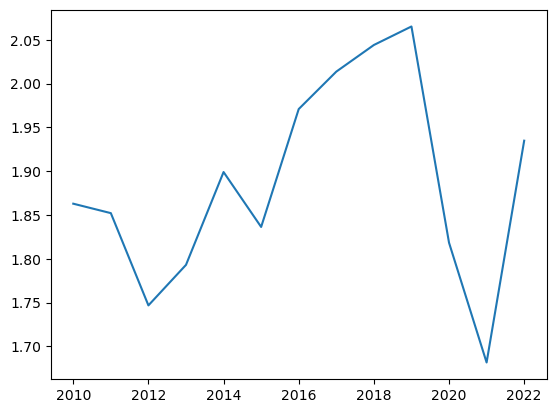

In [18]:
# Extract total housing units and year
boulder_housing_s = pop_housing_boulder_df.set_index('YEAR')['Total Housing Units']

# Use WAC data to compute annual jobs within City of Boulder
wac_boulder_s = wac_city_df.groupby('year')['C000'].sum()

# Compute jobs/housing ratio
jobs_housing_ratio = wac_boulder_s/boulder_housing_s

jobs_housing_ratio.to_clipboard()

jobs_housing_ratio.plot()

## Plot CU student fraction

(0.2, 0.35)

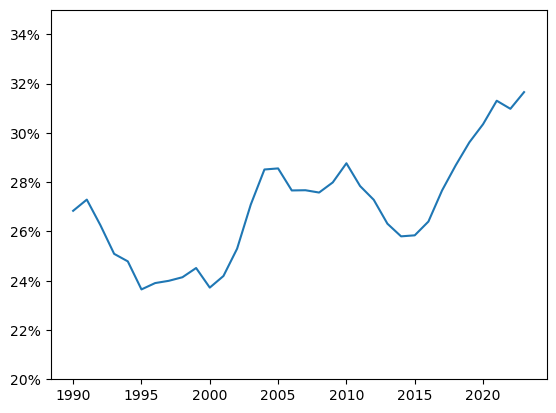

In [19]:
cu_total_enrollments = cu_enrollments_df.set_index('Year')['Total'].dropna()

# Student fraction
total_fraction = cu_total_enrollments / city_pop_s

total_fraction.to_clipboard()

f,ax = plt.subplots()
total_fraction.loc[1990:].plot(ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.set_ylim((.2,.35))

## Plot sister cities growth

In [27]:
place_pops_norm = nhgis_similar_place_df.loc[:,nhgis_name_cols].div(nhgis_similar_place_df.loc[:,'AV0AA1970'],axis=0).T
place_pops_norm.index = [1970,1980,1990,2000,2010,2020]

county_pops_norm = nhgis_similar_county_df.loc[:,nhgis_name_cols].div(nhgis_similar_county_df.loc[:,'AV0AA1970'],axis=0).T
county_pops_norm.index = [1970,1980,1990,2000,2010,2020]

<Axes: >

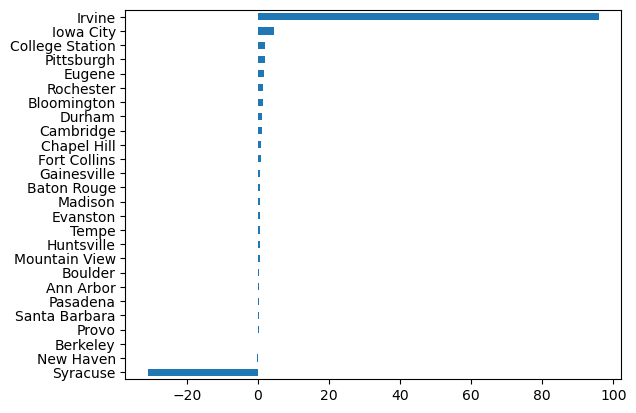

In [24]:
delta_place = (nhgis_similar_place_df['AV0AA2020'] - nhgis_similar_place_df['AV0AA1970'])/nhgis_similar_place_df['AV0AA1970']
delta_place.index = place_names

delta_county = (nhgis_similar_county_df['AV0AA2020'] - nhgis_similar_county_df['AV0AA1970'])/nhgis_similar_county_df['AV0AA1970']
delta_county.index = place_names

delta_ratio = delta_place/delta_county
delta_ratio.sort_values().plot.barh()

<Axes: >

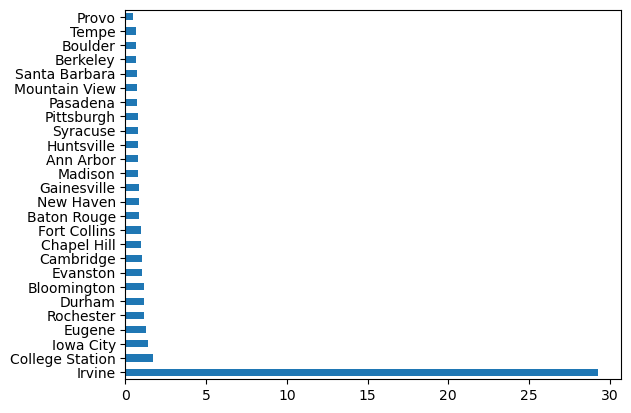

In [26]:
place_pops_norm.columns = place_names
county_pops_norm.columns = place_names

place_pct_county = place_pops_norm.div(county_pops_norm,axis=0)

delta_place_delta_county = place_pct_county.loc[2020,:].sort_values(ascending=False)

delta_place_delta_county.to_clipboard()

delta_place_delta_county.plot.barh()